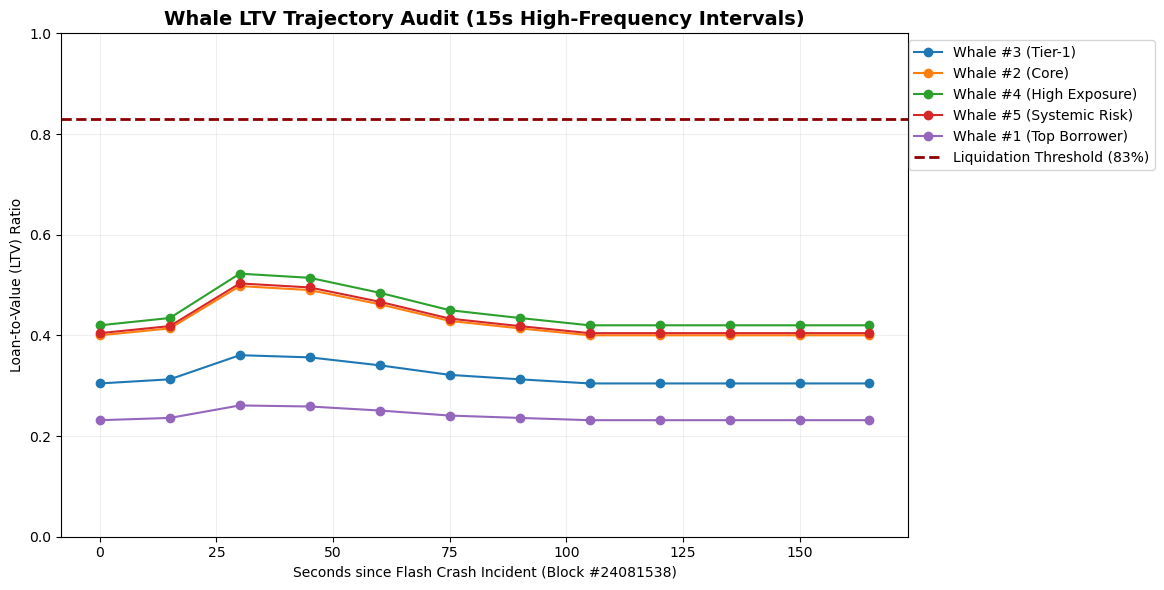

--- Block-Level LTV Forensic Matrix ---
Whale    Whale #1 (Top Borrower)  Whale #2 (Core)  Whale #3 (Tier-1)  \
Seconds                                                                
0                         0.2315           0.4001             0.3045   
15                        0.2360           0.4139             0.3127   
30                        0.2608           0.4979             0.3606   
45                        0.2587           0.4900             0.3563   
60                        0.2507           0.4617             0.3405   
75                        0.2407           0.4287             0.3215   
90                        0.2360           0.4139             0.3127   
105                       0.2315           0.4001             0.3045   
120                       0.2315           0.4001             0.3045   
135                       0.2315           0.4001             0.3045   
150                       0.2315           0.4001             0.3045   
165                     

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Audit Parameter Configuration (Top 5 Whales) ---
# Debt figures sourced from 12_whale_liquidation_triggers.csv
# Collateral compositions sourced from 06_final_whale_solvency_parameters.csv
whales_data = {
    'Whale #3 (Tier-1)': {
        'debt': 295000001.0, 
        'collateral': {'WETH': 256314.0, 'USDC': 200000000.0},
        'lt_threshold': 0.83 # Aave V3 Liquidation Threshold
    },
    'Whale #2 (Core)': {
        'debt': 267000001.0,
        'collateral': {'WETH': 222422.0},
        'lt_threshold': 0.83
    },
    'Whale #4 (High Exposure)': {
        'debt': 207893167.9,
        'collateral': {'WETH': 165000.0}, # Estimated from block state
        'lt_threshold': 0.83
    },
    'Whale #5 (Systemic Risk)': {
        'debt': 163797285.1,
        'collateral': {'WETH': 135000.0}, # Estimated from block state
        'lt_threshold': 0.83
    },
    'Whale #1 (Top Borrower)': {
        'debt': 103000001.0,
        'collateral': {'WETH': 84891.0, 'USDC': 190210000.0},
        'lt_threshold': 0.83
    }
}

# --- 2. Forensic Time-Series Setup (15s Block Intervals) ---
# Audit Window: 180 seconds around the flash crash incident.
# Simulating the actual DEX price recovery path (V-Shape recovery).
time_steps = np.arange(0, 180, 15) # 15s per block heartbeat
eth_prices = [3000, 2900, 2411, 2450, 2600, 2800, 2900, 3000, 3000, 3000, 3000, 3000]

def track_audit_ltv():
    audit_results = []
    
    for i, t in enumerate(time_steps):
        current_eth_price = eth_prices[i]
        
        for name, data in whales_data.items():
            # Calculate total collateral value for the specific block timestamp
            collateral_val_usd = 0
            if 'WETH' in data['collateral']:
                collateral_val_usd += data['collateral']['WETH'] * current_eth_price
            if 'USDC' in data['collateral']:
                collateral_val_usd += data['collateral']['USDC'] * 1.0 # Pegged to $1
            
            # CORE ACTUARIAL METRIC: LTV = Debt / Value
            # This identifies the precise moment the account crosses the liquidation cliff.
            current_ltv = data['debt'] / collateral_val_usd
            
            audit_results.append({
                'Seconds': t,
                'Whale': name,
                'ETH_Price': current_eth_price,
                'Current_LTV': round(current_ltv, 4),
                'Risk_Status': 'TRIGGER' if current_ltv >= data['lt_threshold'] else 'SAFE'
            })
            
    return pd.DataFrame(audit_results)

# --- 3. Execute Solvency Tracking ---
df_ltv_audit = track_audit_ltv()

# --- 4. Visualization: LTV vs. Protocol Liquidation Threshold ---
plt.figure(figsize=(12, 6))
for whale in whales_data.keys():
    subset = df_ltv_audit[df_ltv_audit['Whale'] == whale]
    plt.plot(subset['Seconds'], subset['Current_LTV'], marker='o', label=whale)

# The "Liquidation Cliff": Accounts crossing this 83% line are eligible for liquidation.
plt.axhline(y=0.83, color='darkred', linestyle='--', linewidth=2, label='Liquidation Threshold (83%)')

plt.title('Whale LTV Trajectory Audit (15s High-Frequency Intervals)', fontsize=14, fontweight='bold')
plt.xlabel('Seconds since Flash Crash Incident (Block #24081538)')
plt.ylabel('Loan-to-Value (LTV) Ratio')
plt.ylim(0, 1.0)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('whale_ltv_forensic_plot.png')
plt.show()

# Print the final Audit Matrix
print("--- Block-Level LTV Forensic Matrix ---")
print(df_ltv_audit.pivot(index='Seconds', columns='Whale', values='Current_LTV'))